# 1. Imports


1. Verify hd-bet works for PET images (try with and without skull)
     -> If not look at bet2
   
3. Try in Native space rather than MNI space
   
4. Try ADC if available

5. Expand Dataset
   
     -> Check unprocessed data, ADNI data (possibly ADNI for validation later)

6. Read literature and try different architectures
   
    -> Log metrics on test set after each experiment
        (SSIM, MSE, Inception score)

If use department GPU, make sure don't hog resources (esp if running overnight)

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.utils import progress_bar
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)
from monai.losses.ssim_loss import SSIMLoss

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

In [3]:
%store -r dictionary_train

# 2. MONAI Dataloader

In [4]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair", "pet"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair", "pet"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Resized(keys=["t1", "t1c", "t2", "flair", "pet"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair", "pet"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.6, range_z=0.3),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"])
    ]
)

In [6]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 15.134304523468018 seconds since the loop started


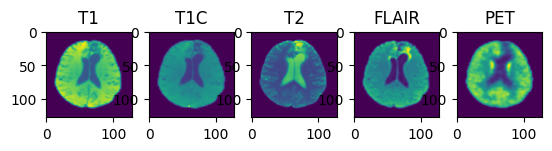

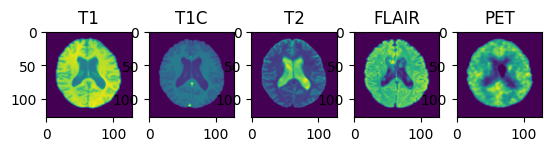

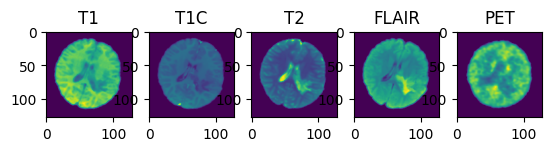

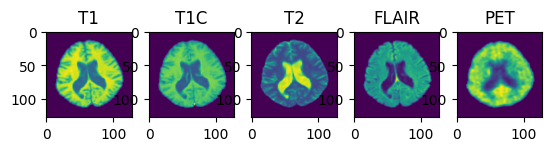

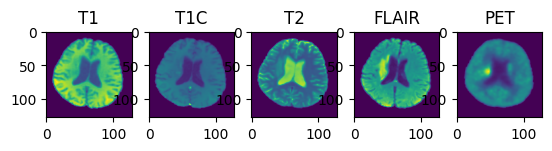

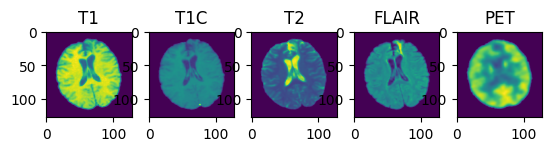

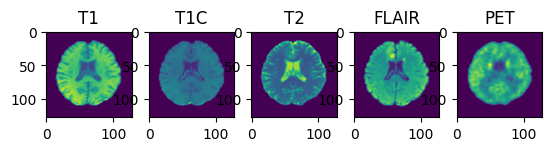

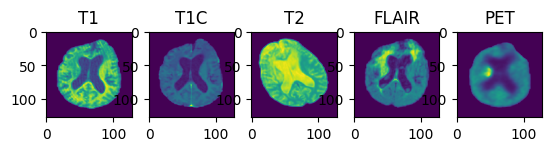

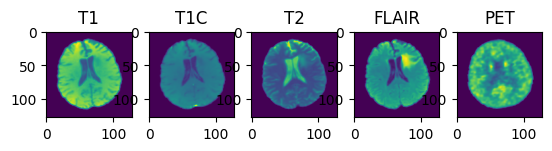

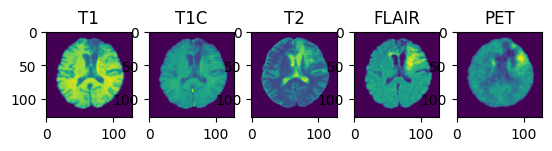

In [7]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index]
    
    f, axarr = plt.subplots(1, 5)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    axarr[4].imshow(image_datas[4])
    axarr[4].set_title("PET")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

In [8]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=os.cpu_count(), drop_last=True)

#valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
#valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

#test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
#test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset:   0%|                                  | 0/247 [00:00<?, ?it/s]

Loading dataset:   0%|                          | 1/247 [00:11<48:09, 11.75s/it]

Loading dataset:   1%|▏                         | 2/247 [00:12<21:32,  5.28s/it]

Loading dataset:   1%|▎                         | 3/247 [00:13<13:43,  3.37s/it]

Loading dataset:   2%|▍                         | 4/247 [00:14<09:28,  2.34s/it]

Loading dataset:   2%|▌                         | 5/247 [00:18<11:31,  2.86s/it]

Loading dataset:   2%|▋                         | 6/247 [00:19<08:53,  2.21s/it]

Loading dataset:   9%|██▏                      | 21/247 [00:19<01:11,  3.16it/s]

Loading dataset:   9%|██▏                      | 22/247 [00:20<01:07,  3.34it/s]

Loading dataset:   9%|██▎                      | 23/247 [00:21<01:33,  2.40it/s]

Loading dataset:  10%|██▍                      | 24/247 [00:22<01:56,  1.92it/s]

Loading dataset:  10%|██▌                      | 25/247 [00:24<02:25,  1.53it/s]

Loading dataset:  11%|██▋                      | 26/247 [00:24<02:23,  1.54it/s]

Loading dataset:  11%|██▋                      | 27/247 [00:26<02:53,  1.27it/s]

Loading dataset:  11%|██▊                      | 28/247 [00:26<02:20,  1.55it/s]

Loading dataset:  12%|██▉                      | 29/247 [00:26<01:57,  1.85it/s]

Loading dataset:  12%|███                      | 30/247 [00:26<01:39,  2.18it/s]

Loading dataset:  13%|███▏                     | 31/247 [00:26<01:24,  2.56it/s]

Loading dataset:  13%|███▏                     | 32/247 [00:27<01:43,  2.08it/s]

Loading dataset:  13%|███▎                     | 33/247 [00:28<01:51,  1.91it/s]

Loading dataset:  14%|███▍                     | 34/247 [00:28<01:33,  2.27it/s]

Loading dataset:  14%|███▌                     | 35/247 [00:29<01:44,  2.04it/s]

Loading dataset:  15%|███▋                     | 36/247 [00:29<01:46,  1.98it/s]

Loading dataset:  15%|███▋                     | 37/247 [00:29<01:21,  2.57it/s]

Loading dataset:  15%|███▊                     | 38/247 [00:30<01:12,  2.90it/s]

Loading dataset:  16%|███▉                     | 39/247 [00:30<00:57,  3.61it/s]

Loading dataset:  17%|████▎                    | 42/247 [00:30<00:31,  6.54it/s]

Loading dataset:  17%|████▎                    | 43/247 [00:31<01:22,  2.46it/s]

Loading dataset:  18%|████▍                    | 44/247 [00:31<01:13,  2.75it/s]

Loading dataset:  18%|████▌                    | 45/247 [00:32<01:25,  2.37it/s]

Loading dataset:  19%|████▋                    | 46/247 [00:33<01:45,  1.91it/s]

Loading dataset:  19%|████▊                    | 47/247 [00:34<02:07,  1.57it/s]

Loading dataset:  19%|████▊                    | 48/247 [00:35<02:47,  1.19it/s]

Loading dataset:  20%|████▉                    | 49/247 [00:36<02:25,  1.36it/s]

Loading dataset:  20%|█████                    | 50/247 [00:36<01:48,  1.81it/s]

Loading dataset:  21%|█████▏                   | 51/247 [00:36<01:42,  1.91it/s]

Loading dataset:  21%|█████▎                   | 52/247 [00:37<01:49,  1.78it/s]

Loading dataset:  22%|█████▍                   | 54/247 [00:37<01:14,  2.58it/s]

Loading dataset:  22%|█████▌                   | 55/247 [00:37<01:09,  2.78it/s]

Loading dataset:  23%|█████▊                   | 57/247 [00:39<01:29,  2.12it/s]

Loading dataset:  23%|█████▊                   | 58/247 [00:39<01:16,  2.46it/s]

Loading dataset:  24%|█████▉                   | 59/247 [00:39<01:03,  2.94it/s]

Loading dataset:  25%|██████▏                  | 61/247 [00:39<00:45,  4.13it/s]

Loading dataset:  25%|██████▎                  | 62/247 [00:40<01:25,  2.16it/s]

Loading dataset:  26%|██████▍                  | 63/247 [00:42<02:10,  1.41it/s]

Loading dataset:  26%|██████▍                  | 64/247 [00:43<02:10,  1.40it/s]

Loading dataset:  26%|██████▌                  | 65/247 [00:43<02:11,  1.39it/s]

Loading dataset:  27%|██████▋                  | 66/247 [00:44<01:50,  1.65it/s]

Loading dataset:  27%|██████▊                  | 67/247 [00:44<01:33,  1.92it/s]

Loading dataset:  28%|██████▉                  | 68/247 [00:44<01:25,  2.09it/s]

Loading dataset:  28%|██████▉                  | 69/247 [00:45<01:55,  1.54it/s]

Loading dataset:  28%|███████                  | 70/247 [00:46<01:47,  1.65it/s]

Loading dataset:  29%|███████▏                 | 71/247 [00:46<01:40,  1.75it/s]

Loading dataset:  29%|███████▎                 | 72/247 [00:47<01:38,  1.78it/s]

Loading dataset:  30%|███████▍                 | 73/247 [00:47<01:20,  2.17it/s]

Loading dataset:  31%|███████▋                 | 76/247 [00:48<00:52,  3.25it/s]

Loading dataset:  31%|███████▊                 | 77/247 [00:48<00:46,  3.65it/s]

Loading dataset:  32%|███████▉                 | 78/247 [00:48<00:45,  3.68it/s]

Loading dataset:  32%|███████▉                 | 79/247 [00:49<00:51,  3.25it/s]

Loading dataset:  32%|████████                 | 80/247 [00:49<01:10,  2.38it/s]

Loading dataset:  33%|████████▏                | 81/247 [00:50<01:08,  2.41it/s]

Loading dataset:  33%|████████▎                | 82/247 [00:51<01:49,  1.51it/s]

Loading dataset:  34%|████████▍                | 83/247 [00:51<01:37,  1.69it/s]

Loading dataset:  34%|████████▌                | 84/247 [00:53<02:01,  1.35it/s]

Loading dataset:  34%|████████▌                | 85/247 [00:54<02:21,  1.15it/s]

Loading dataset:  35%|████████▋                | 86/247 [00:55<02:47,  1.04s/it]

Loading dataset:  35%|████████▊                | 87/247 [00:55<02:11,  1.21it/s]

Loading dataset:  36%|████████▉                | 88/247 [00:56<02:02,  1.30it/s]

Loading dataset:  36%|█████████                | 89/247 [00:56<01:36,  1.63it/s]

Loading dataset:  38%|█████████▌               | 94/247 [00:57<00:42,  3.56it/s]

Loading dataset:  38%|█████████▌               | 95/247 [00:57<00:45,  3.35it/s]

Loading dataset:  39%|█████████▋               | 96/247 [00:58<01:05,  2.30it/s]

Loading dataset:  39%|█████████▊               | 97/247 [00:59<00:55,  2.71it/s]

Loading dataset:  40%|█████████▉               | 98/247 [00:59<00:52,  2.85it/s]

Loading dataset:  40%|██████████               | 99/247 [00:59<00:51,  2.86it/s]

Loading dataset:  40%|█████████▋              | 100/247 [00:59<00:44,  3.34it/s]

Loading dataset:  41%|█████████▊              | 101/247 [01:01<01:31,  1.60it/s]

Loading dataset:  41%|█████████▉              | 102/247 [01:03<02:45,  1.14s/it]

Loading dataset:  42%|██████████              | 103/247 [01:03<02:06,  1.14it/s]

Loading dataset:  42%|██████████              | 104/247 [01:05<02:14,  1.07it/s]

Loading dataset:  43%|██████████▏             | 105/247 [01:05<02:11,  1.08it/s]

Loading dataset:  43%|██████████▎             | 106/247 [01:06<01:36,  1.46it/s]

Loading dataset:  43%|██████████▍             | 107/247 [01:06<01:19,  1.76it/s]

Loading dataset:  44%|██████████▍             | 108/247 [01:06<01:09,  2.00it/s]

Loading dataset:  44%|██████████▌             | 109/247 [01:06<00:53,  2.58it/s]

Loading dataset:  45%|██████████▊             | 111/247 [01:07<00:34,  3.97it/s]

Loading dataset:  46%|███████████             | 114/247 [01:07<00:22,  5.91it/s]

Loading dataset:  47%|███████████▏            | 115/247 [01:08<00:44,  2.98it/s]

Loading dataset:  47%|███████████▎            | 116/247 [01:08<00:45,  2.88it/s]

Loading dataset:  47%|███████████▎            | 117/247 [01:09<00:50,  2.57it/s]

Loading dataset:  48%|███████████▍            | 118/247 [01:09<00:49,  2.63it/s]

Loading dataset:  48%|███████████▌            | 119/247 [01:10<00:56,  2.26it/s]

Loading dataset:  49%|███████████▋            | 120/247 [01:10<00:54,  2.33it/s]

Loading dataset:  49%|███████████▊            | 121/247 [01:11<01:16,  1.65it/s]

Loading dataset:  49%|███████████▊            | 122/247 [01:12<01:07,  1.84it/s]

Loading dataset:  50%|███████████▉            | 123/247 [01:12<00:53,  2.33it/s]

Loading dataset:  50%|████████████            | 124/247 [01:12<00:43,  2.82it/s]

Loading dataset:  51%|████████████▏           | 125/247 [01:13<01:00,  2.02it/s]

Loading dataset:  51%|████████████▏           | 126/247 [01:13<00:55,  2.19it/s]

Loading dataset:  51%|████████████▎           | 127/247 [01:14<01:22,  1.45it/s]

Loading dataset:  52%|████████████▍           | 128/247 [01:15<01:19,  1.50it/s]

Loading dataset:  52%|████████████▌           | 129/247 [01:15<01:14,  1.59it/s]

Loading dataset:  53%|████████████▋           | 130/247 [01:16<01:08,  1.72it/s]

Loading dataset:  53%|████████████▋           | 131/247 [01:16<00:53,  2.18it/s]

Loading dataset:  53%|████████████▊           | 132/247 [01:17<01:14,  1.54it/s]

Loading dataset:  55%|█████████████           | 135/247 [01:19<00:59,  1.87it/s]

Loading dataset:  55%|█████████████▏          | 136/247 [01:19<00:54,  2.05it/s]

Loading dataset:  55%|█████████████▎          | 137/247 [01:19<00:51,  2.13it/s]

Loading dataset:  56%|█████████████▍          | 138/247 [01:20<00:51,  2.13it/s]

Loading dataset:  56%|█████████████▌          | 139/247 [01:21<01:01,  1.75it/s]

Loading dataset:  57%|█████████████▌          | 140/247 [01:21<00:49,  2.18it/s]

Loading dataset:  57%|█████████████▋          | 141/247 [01:22<01:11,  1.48it/s]

Loading dataset:  57%|█████████████▊          | 142/247 [01:22<01:02,  1.69it/s]

Loading dataset:  58%|█████████████▉          | 143/247 [01:22<00:47,  2.18it/s]

Loading dataset:  58%|█████████████▉          | 144/247 [01:23<00:38,  2.67it/s]

Loading dataset:  59%|██████████████          | 145/247 [01:25<01:23,  1.22it/s]

Loading dataset:  59%|██████████████▏         | 146/247 [01:25<01:11,  1.42it/s]

Loading dataset:  60%|██████████████▎         | 147/247 [01:25<00:57,  1.75it/s]

Loading dataset:  60%|██████████████▍         | 148/247 [01:25<00:46,  2.15it/s]

Loading dataset:  60%|██████████████▍         | 149/247 [01:26<00:42,  2.30it/s]

Loading dataset:  61%|██████████████▋         | 151/247 [01:26<00:31,  3.09it/s]

Loading dataset:  62%|██████████████▊         | 152/247 [01:27<00:37,  2.51it/s]

Loading dataset:  62%|██████████████▊         | 153/247 [01:27<00:41,  2.26it/s]

Loading dataset:  62%|██████████████▉         | 154/247 [01:28<00:40,  2.31it/s]

Loading dataset:  63%|███████████████         | 155/247 [01:29<00:48,  1.91it/s]

Loading dataset:  63%|███████████████▏        | 156/247 [01:30<01:05,  1.39it/s]

Loading dataset:  64%|███████████████▎        | 157/247 [01:30<00:49,  1.81it/s]

Loading dataset:  64%|███████████████▎        | 158/247 [01:30<00:37,  2.35it/s]

Loading dataset:  64%|███████████████▍        | 159/247 [01:31<00:32,  2.71it/s]

Loading dataset:  65%|███████████████▌        | 160/247 [01:31<00:32,  2.65it/s]

Loading dataset:  65%|███████████████▋        | 161/247 [01:31<00:29,  2.87it/s]

Loading dataset:  66%|███████████████▋        | 162/247 [01:32<00:35,  2.39it/s]

Loading dataset:  66%|███████████████▊        | 163/247 [01:32<00:37,  2.25it/s]

Loading dataset:  66%|███████████████▉        | 164/247 [01:32<00:35,  2.32it/s]

Loading dataset:  68%|████████████████▏       | 167/247 [01:35<00:53,  1.51it/s]

Loading dataset:  68%|████████████████▎       | 168/247 [01:35<00:43,  1.83it/s]

Loading dataset:  68%|████████████████▍       | 169/247 [01:35<00:38,  2.02it/s]

Loading dataset:  69%|████████████████▌       | 170/247 [01:36<00:31,  2.42it/s]

Loading dataset:  69%|████████████████▌       | 171/247 [01:36<00:31,  2.41it/s]

Loading dataset:  70%|████████████████▋       | 172/247 [01:36<00:26,  2.83it/s]

Loading dataset:  70%|████████████████▊       | 173/247 [01:38<00:55,  1.34it/s]

Loading dataset:  70%|████████████████▉       | 174/247 [01:38<00:42,  1.71it/s]

Loading dataset:  71%|█████████████████       | 175/247 [01:39<00:39,  1.81it/s]

Loading dataset:  71%|█████████████████       | 176/247 [01:39<00:31,  2.25it/s]

Loading dataset:  72%|█████████████████▎      | 178/247 [01:39<00:26,  2.56it/s]

Loading dataset:  72%|█████████████████▍      | 179/247 [01:40<00:27,  2.46it/s]

Loading dataset:  73%|█████████████████▍      | 180/247 [01:41<00:37,  1.78it/s]

Loading dataset:  73%|█████████████████▌      | 181/247 [01:41<00:35,  1.87it/s]

Loading dataset:  74%|█████████████████▋      | 182/247 [01:41<00:27,  2.39it/s]

Loading dataset:  74%|█████████████████▊      | 183/247 [01:42<00:33,  1.90it/s]

Loading dataset:  74%|█████████████████▉      | 184/247 [01:43<00:32,  1.96it/s]

Loading dataset:  75%|█████████████████▉      | 185/247 [01:43<00:26,  2.30it/s]

Loading dataset:  75%|██████████████████      | 186/247 [01:43<00:26,  2.32it/s]

Loading dataset:  76%|██████████████████▏     | 187/247 [01:44<00:24,  2.47it/s]

Loading dataset:  76%|██████████████████▎     | 188/247 [01:44<00:23,  2.47it/s]

Loading dataset:  77%|██████████████████▎     | 189/247 [01:45<00:30,  1.92it/s]

Loading dataset:  77%|██████████████████▍     | 190/247 [01:45<00:26,  2.18it/s]

Loading dataset:  77%|██████████████████▌     | 191/247 [01:47<00:41,  1.34it/s]

Loading dataset:  78%|██████████████████▊     | 193/247 [01:48<00:41,  1.30it/s]

Loading dataset:  79%|██████████████████▊     | 194/247 [01:48<00:33,  1.60it/s]

Loading dataset:  79%|██████████████████▉     | 195/247 [01:49<00:31,  1.64it/s]

Loading dataset:  79%|███████████████████     | 196/247 [01:49<00:28,  1.78it/s]

Loading dataset:  80%|███████████████████▏    | 197/247 [01:50<00:29,  1.68it/s]

Loading dataset:  80%|███████████████████▏    | 198/247 [01:50<00:22,  2.18it/s]

Loading dataset:  81%|███████████████████▎    | 199/247 [01:50<00:18,  2.54it/s]

Loading dataset:  81%|███████████████████▍    | 200/247 [01:51<00:14,  3.18it/s]

Loading dataset:  81%|███████████████████▌    | 201/247 [01:52<00:23,  1.99it/s]

Loading dataset:  82%|███████████████████▋    | 202/247 [01:52<00:18,  2.46it/s]

Loading dataset:  82%|███████████████████▋    | 203/247 [01:52<00:17,  2.53it/s]

Loading dataset:  83%|███████████████████▊    | 204/247 [01:53<00:20,  2.14it/s]

Loading dataset:  83%|███████████████████▉    | 205/247 [01:53<00:19,  2.10it/s]

Loading dataset:  83%|████████████████████    | 206/247 [01:54<00:26,  1.57it/s]

Loading dataset:  84%|████████████████████    | 207/247 [01:55<00:21,  1.88it/s]

Loading dataset:  84%|████████████████████▏   | 208/247 [01:55<00:17,  2.27it/s]

Loading dataset:  85%|████████████████████▎   | 209/247 [01:55<00:18,  2.02it/s]

Loading dataset:  85%|████████████████████▍   | 210/247 [01:56<00:15,  2.41it/s]

Loading dataset:  85%|████████████████████▌   | 211/247 [01:56<00:17,  2.07it/s]

Loading dataset:  86%|████████████████████▌   | 212/247 [01:57<00:16,  2.12it/s]

Loading dataset:  86%|████████████████████▋   | 213/247 [01:57<00:14,  2.31it/s]

Loading dataset:  87%|████████████████████▊   | 214/247 [01:57<00:13,  2.36it/s]

Loading dataset:  87%|████████████████████▉   | 215/247 [01:58<00:13,  2.44it/s]

Loading dataset:  87%|████████████████████▉   | 216/247 [01:58<00:11,  2.71it/s]

Loading dataset:  88%|█████████████████████   | 217/247 [01:59<00:13,  2.18it/s]

Loading dataset:  88%|█████████████████████▏  | 218/247 [01:59<00:14,  2.04it/s]

Loading dataset:  89%|█████████████████████▎  | 219/247 [02:00<00:17,  1.64it/s]

Loading dataset:  89%|█████████████████████▍  | 220/247 [02:01<00:18,  1.47it/s]

Loading dataset:  89%|█████████████████████▍  | 221/247 [02:01<00:15,  1.70it/s]

Loading dataset:  90%|█████████████████████▌  | 222/247 [02:02<00:12,  1.93it/s]

Loading dataset:  90%|█████████████████████▋  | 223/247 [02:02<00:11,  2.06it/s]

Loading dataset:  91%|█████████████████████▊  | 224/247 [02:03<00:11,  2.04it/s]

Loading dataset:  91%|█████████████████████▊  | 225/247 [02:03<00:10,  2.10it/s]

Loading dataset:  91%|█████████████████████▉  | 226/247 [02:04<00:14,  1.42it/s]

Loading dataset:  92%|██████████████████████  | 227/247 [02:05<00:13,  1.50it/s]

Loading dataset:  92%|██████████████████████▏ | 228/247 [02:05<00:09,  1.92it/s]

Loading dataset:  93%|██████████████████████▎ | 229/247 [02:05<00:07,  2.46it/s]

Loading dataset:  96%|██████████████████████▉ | 236/247 [02:05<00:01,  8.61it/s]

Loading dataset:  98%|███████████████████████▍| 241/247 [02:06<00:00, 12.65it/s]

Loading dataset: 100%|████████████████████████| 247/247 [02:06<00:00, 18.07it/s]

Loading dataset: 100%|████████████████████████| 247/247 [02:06<00:00,  1.96it/s]

# 3. Model Setup


In [9]:
class GLA_Generator(nn.Module):
    def __init__(self):
        super(GLA_Generator, self).__init__()
        self.ahnet_global = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)

        channels = [6, 6, 6]
        strides = [1, 1, 1]
        
        self.ahnet_1 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_2 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_3 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_4 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)

        self.conv1 = nn.Conv3d(32, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=1)
        self.bn2 = nn.BatchNorm3d(1)

    def forward(self, x):
        batch_size, channels, width, height, depth = x.shape
        half_width, half_height = width // 2, height // 2
        
        # Splitting the input into 4 patches
        patch_1 = x[:, :, :half_width, :half_height, :]
        patch_2 = x[:, :, :half_width, half_height:, :]
        patch_3 = x[:, :, half_width:, :half_height, :]
        patch_4 = x[:, :, half_width:, half_height:, :]

        x = self.ahnet_global(x)
        patch_1 = self.ahnet_1(patch_1)
        patch_2 = self.ahnet_2(patch_2)
        patch_3 = self.ahnet_3(patch_3)
        patch_4 = self.ahnet_4(patch_4)

        # Concatenating the processed patches
        top_row = torch.cat([patch_1, patch_2], dim=3)  # Concatenate along the height
        bottom_row = torch.cat([patch_3, patch_4], dim=3)  # Concatenate along the height
        concatenated_patches = torch.cat([top_row, bottom_row], dim=2)  # Concatenate along the width

        x = torch.cat([x, concatenated_patches], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return x

### 3.1 Model and Device Setup

In [10]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gen_net = GLA_Generator()

disc_net = monai.networks.nets.Discriminator(
    in_shape=(128, 128, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=3,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    gen_net = nn.DataParallel(gen_net)
    disc_net = nn.DataParallel(disc_net)

gen_net.to(device)
disc_net.to(device)

real_label = 1
gen_label = 0

disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()
gen_loss2 = SSIMLoss(spatial_dims=3)

disc_opt = torch.optim.Adam(disc_net.parameters(), 0.0001)
gen_opt = torch.optim.Adam(gen_net.parameters(), 0.0001)

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    # Training discriminator to label 1 on real images
    realloss = disc_loss(disc_net(real_images), real) 

    # Training discriminator to label 0 on generated images
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input, real_images):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input[:,0,:,:,:])
    cats = output.new_full(output.shape, real_label)
    fooling_disc = gen_loss(output, cats)
    ssim = gen_loss2(input, real_images)
    
    # Train generator to fool the discriminator into giving a score of 1, and to have a high SSIM
    return fooling_disc + ssim

cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Let's use 3 GPUs!


### 3.2 Training


In [11]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0
max_epochs = 100
disc_train_interval = 1
disc_train_steps = 4
torch.cuda.empty_cache()

for epoch in range(max_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    for i, batch_data in enumerate(train_loader):
        progress_bar(
            i,
            len(train_loader),
            f"epoch {epoch + 1}, avg loss: {epoch_loss_values[-1][1]:.4f}",
        )
        input_images = torch.cat((batch_data["t1"].to(device, dtype=torch.float), 
                                 batch_data["t1c"].to(device, dtype=torch.float), 
                                 batch_data["t2"].to(device, dtype=torch.float), 
                                 batch_data["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        real_pet = batch_data["pet"].to(device, dtype=torch.float)
        
        gen_opt.zero_grad()
        gen_images = gen_net(input_images)
        loss = generator_loss(gen_images, real_pet)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        real_pet = real_pet[:,0,:,:,:]
        gen_images = gen_images[:,0,:,:,:]

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_pet)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))

        step += 1

    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

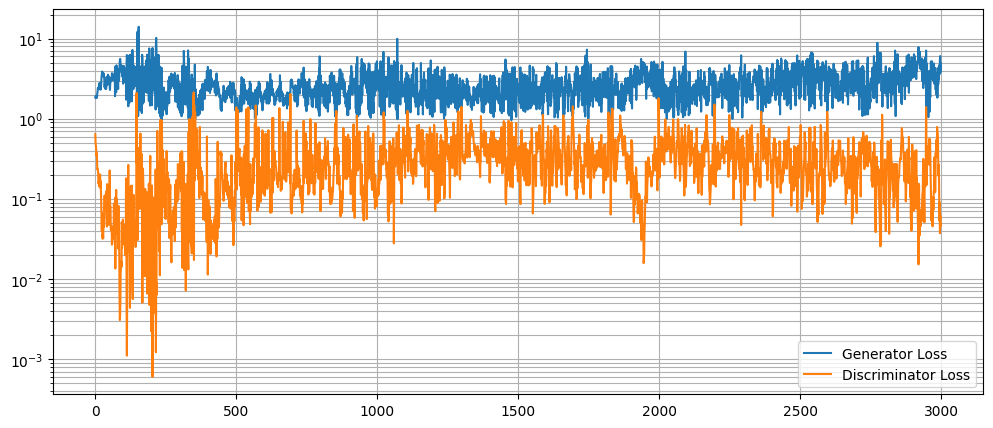

In [12]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

It has been 12.35502004623413 seconds since the loop started


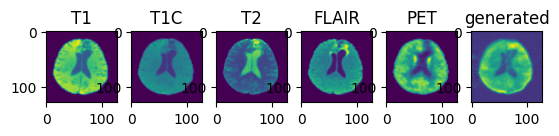

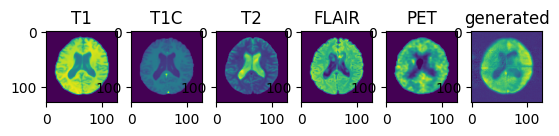

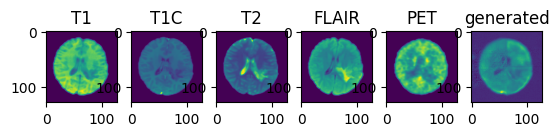

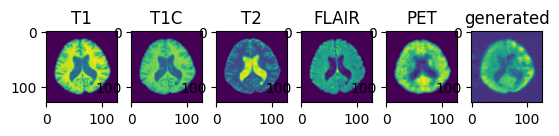

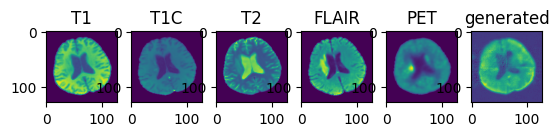

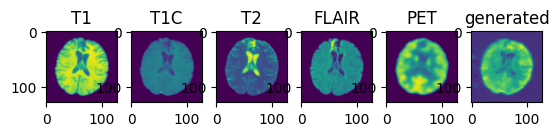

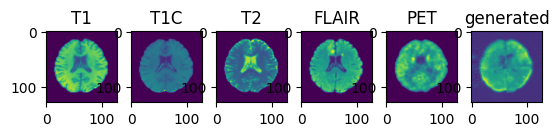

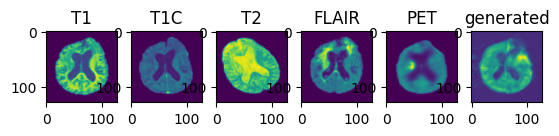

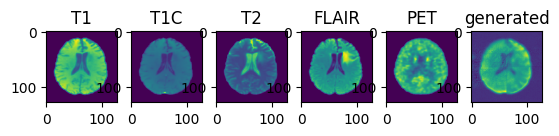

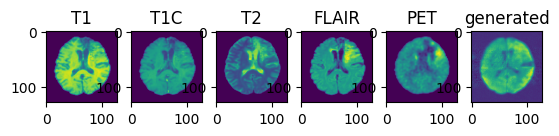

In [13]:
program_starts = time()
step = 1350
slice_index = 32
torch.cuda.empty_cache()
gen_net.eval()

for item in check_DataLoader:

    with torch.no_grad():
        
        input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)
        
        image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], gen_net(input_images)[0, 0, :, :, slice_index] 
        
        f, axarr = plt.subplots(1, 6)
        
        axarr[0].imshow(image_datas[0])
        axarr[0].set_title("T1")
        axarr[1].imshow(image_datas[1])
        axarr[1].set_title("T1C")
        axarr[2].imshow(image_datas[2])
        axarr[2].set_title("T2")
        axarr[3].imshow(image_datas[3])
        axarr[3].set_title("FLAIR")
        axarr[4].imshow(image_datas[4])
        axarr[4].set_title("PET")
        axarr[5].imshow(image_datas[5].cpu())
        axarr[5].set_title("generated")
        
        step += 1


now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))